# Wind Speed Prediction in Arizona

This notebook retrieves a small subset of ERA5 data, preprocesses it, and trains a simple LSTM model to predict the next day’s wind speed. The code is optimized for a quick test rather than long-running experiments.


In [1]:
# Install required packages if necessary (uncomment if needed):
# !pip install cdsapi xarray numpy pandas scikit-learn tensorflow matplotlib

import os
import cdsapi
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from math import sqrt


## Step 1: Data Retrieval

We fetch a small ERA5 dataset (one month, small region in Arizona) to keep things fast and simple.


In [2]:
print("Starting data retrieval...")

lat_min, lat_max = 33, 34
lon_min, lon_max = -112, -111
data_file = 'era5_arizona_data.nc'

if not os.path.exists(data_file):
    print("Fetching a smaller dataset from CDS API for a quicker run...")
    c = cdsapi.Client()
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': [
                '10m_u_component_of_wind','10m_v_component_of_wind'
            ],
            'year': ['2021'],
            'month': ['01'], 
            'day': [f"{d:02d}" for d in range(1,32)],
            'time': [f"{h:02d}:00" for h in range(24)],
            'area': [lat_max, lon_min, lat_min, lon_max],
            'format': 'netcdf'
        },
        data_file)
    print("Data downloaded.")
else:
    print("Data file already exists, skipping download.")


Starting data retrieval...
Data file already exists, skipping download.


## Step 2: Load Dataset


In [3]:
print("Loading dataset...")
ds = xr.open_dataset(data_file)
print("Dataset loaded. Dimensions:", ds.dims)


Loading dataset...
Dataset loaded. Dimensions: FrozenMappingWarningOnValuesAccess({'valid_time': 2160, 'latitude': 25, 'longitude': 29})


## Step 3: Data Preprocessing

Compute wind speed and reduce to daily averages. Normalize the data for the LSTM.


In [4]:
if 'valid_time' in ds.dims or 'valid_time' in ds.variables:
    ds = ds.rename({'valid_time': 'time'})

print("Computing wind speed and daily averages...")
ds['wind_speed'] = np.sqrt(ds['u10']**2 + ds['v10']**2)

ds_daily = ds.resample(time='1D').mean()
df_daily = ds_daily.to_dataframe().reset_index()
print("Daily aggregated data shape:", df_daily.shape)

df_daily = df_daily.dropna(subset=['wind_speed'])
print("After dropping NaNs, data shape:", df_daily.shape)

features = ['wind_speed']
data = df_daily[features].values

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
print("Data normalized.")

look_back = 7
X, y = [], []
for i in range(len(data_scaled)-look_back):
    X.append(data_scaled[i:i+look_back,:])
    y.append(data_scaled[i+look_back,0])

X = np.array(X)
y = np.array(y)

print("Input shape:", X.shape, "Output shape:", y.shape)

train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Computing wind speed and daily averages...
Daily aggregated data shape: (65250, 9)
After dropping NaNs, data shape: (65250, 9)
Data normalized.
Input shape: (65243, 7, 1) Output shape: (65243,)
Train size: (52194, 7, 1) Test size: (13049, 7, 1)


## Step 4: Model Development

A small LSTM model is used for speed. We train it for a few epochs only.


In [5]:
print("Building and training LSTM model...")

model = Sequential()
model.add(LSTM(32, input_shape=(look_back, X.shape[2])))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=3, batch_size=16, verbose=1)

print("Model training complete.")


Building and training LSTM model...
Epoch 1/3
3263/3263 [==============================] - 15s 4ms/step - loss: 0.0044
Epoch 2/3
3263/3263 [==============================] - 11s 3ms/step - loss: 0.0028
Epoch 3/3
3263/3263 [==============================] - 12s 4ms/step - loss: 0.0027
Model training complete.


## Step 5: Evaluation Metrics

Evaluate the model using MAE and RMSE. Transform predictions back to original scale.


In [6]:
print("Evaluating model...")

y_pred = model.predict(X_test)

inv_pred = np.zeros((len(y_pred), data.shape[1]))
inv_pred[:,0] = y_pred[:,0]
inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:,0]

inv_y = np.zeros((len(y_test), data.shape[1]))
inv_y[:,0] = y_test[:]
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

mae = np.mean(np.abs(inv_pred - inv_y))
rmse = sqrt(np.mean((inv_pred - inv_y)**2))

print("MAE:", mae)
print("RMSE:", rmse)


Evaluating model...
408/408 [==============================] - 2s 3ms/step
MAE: 0.3822988779536615
RMSE: 0.5843891016889426


## Results and Analysis

Visualize predictions vs. actual values.


     Actual  Predicted
0  1.549456   0.946925
1  1.702704   1.689036
2  1.864588   1.963001
3  1.992311   2.033444
4  2.340106   2.063800


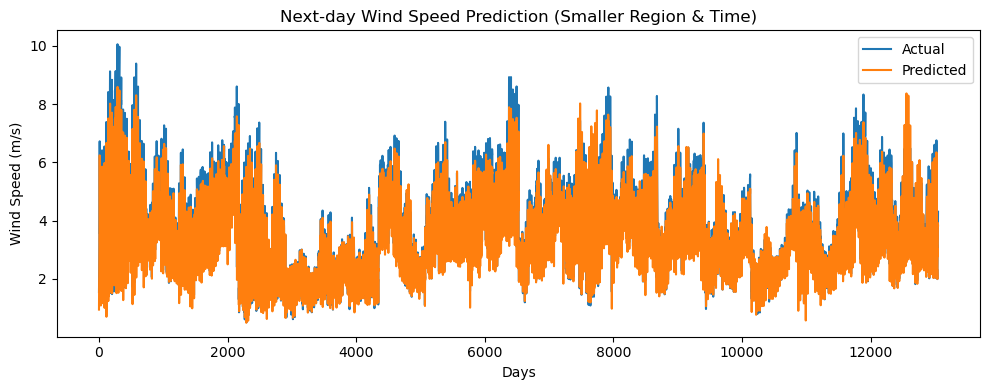

Done.


In [7]:
results_df = pd.DataFrame({'Actual': inv_y, 'Predicted': inv_pred})
print(results_df.head())

plt.figure(figsize=(10,4))
plt.plot(results_df['Actual'].values, label='Actual')
plt.plot(results_df['Predicted'].values, label='Predicted')
plt.title('Next-day Wind Speed Prediction (Smaller Region & Time)')
plt.xlabel('Days')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.tight_layout()
plt.show()

print("Done.")


## Additional Error Analysis

Calculate more metrics (MAPE, R²) and visualize error distributions.


MAPE: 11.53451248966567
R²: 0.83006284101144


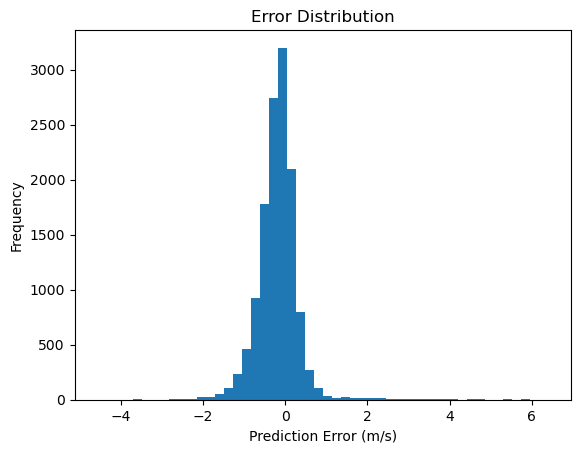

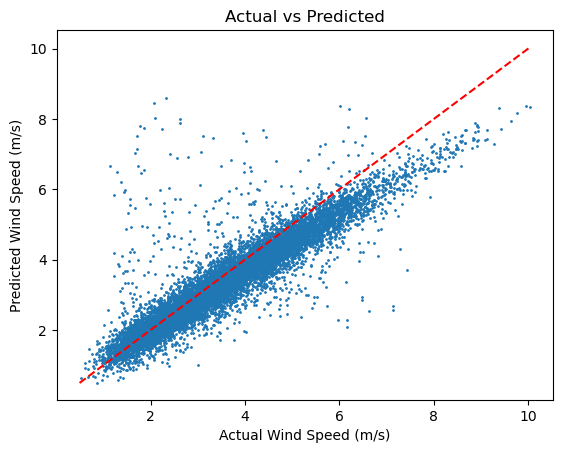

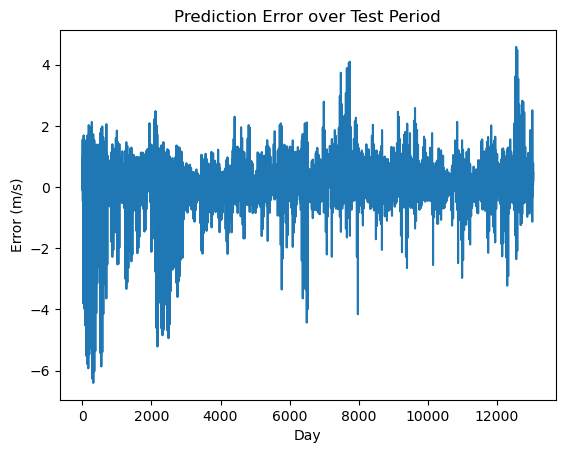

Extended analysis complete.


In [8]:
mape = np.mean(np.abs((inv_pred - inv_y) / inv_y)) * 100
ss_res = np.sum((inv_y - inv_pred)**2)
ss_tot = np.sum((inv_y - np.mean(inv_y))**2)
r2 = 1 - (ss_res / ss_tot)

print("MAPE:", mape)
print("R²:", r2)

errors = inv_pred - inv_y
plt.figure()
plt.hist(errors, bins=50)
plt.title("Error Distribution")
plt.xlabel("Prediction Error (m/s)")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.scatter(inv_y, inv_pred, s=1)
plt.title("Actual vs Predicted")
plt.xlabel("Actual Wind Speed (m/s)")
plt.ylabel("Predicted Wind Speed (m/s)")
min_val = min(inv_y.min(), inv_pred.min())
max_val = max(inv_y.max(), inv_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.show()

plt.figure()
plt.plot(inv_y - inv_pred)
plt.title("Prediction Error over Test Period")
plt.xlabel("Day")
plt.ylabel("Error (m/s)")
plt.show()

print("Extended analysis complete.")
